In [36]:
import os
import sys
import platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets
import sklearn as sk
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

In [37]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

print("Stai utilizzando il dispositivo:", device)

Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.1

Python 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Pandas 2.2.2
Scikit-Learn 1.4.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps
Stai utilizzando il dispositivo: mps


In [38]:
TRAIN_DATA_PATH = "/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/train"
TEST_DATA_PATH = "/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spettrogrammi/test"

In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None, augmentations=None):
        self.image_paths = image_paths
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = int(image_path.split("/")[-1].split("_")[0])-1
        image = Image.open(image_path).convert("RGB").crop((102, 49, 708, 584))

        if self.transform:
            image = self.transform(image)

        if self.augmentations:
            # apply transformations with probability of 0.5
            if np.random.rand() > 0.5:
                image = self.augmentations(image)

        return image, label

In [40]:
def get_images_paths(folder_path=None):
    if folder_path is None:
        raise ValueError("folder_path cannot be None. It must be TRAIN_DATA_PATH or TEST_DATA_PATH.")

    if folder_path != TRAIN_DATA_PATH and folder_path != TEST_DATA_PATH:
        raise ValueError("folder_path must be TRAIN_DATA_PATH or TEST_DATA_PATH.")

    images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"):
                images.append(os.path.join(root, file))
    return images

In [41]:
def get_train_valid_loader(train_size=0.8, batch_size=32, num_workers=0):

    images_paths = get_images_paths(TRAIN_DATA_PATH)
    np.random.shuffle(images_paths)
    train_images_paths = images_paths[:int(len(images_paths) * train_size)]
    valid_images_paths = images_paths[int(len(images_paths) * train_size):]

    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    augumentation_transform = transforms.Compose([
        transforms.RandomRotation(3),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.001, contrast=0.001, saturation=0.001, hue=0)
    ])

    train_dataset = Dataset(train_images_paths, transform=base_transform, augmentations=augumentation_transform)
    valid_dataset = Dataset(valid_images_paths, transform=base_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, valid_loader

In [42]:
def get_test_loader(batch_size=32, num_workers=0, shuffle=True):
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_paths = get_images_paths(TEST_DATA_PATH)
    test_dataset = Dataset(image_paths, transform=base_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return test_loader

 gestione e del conteggio delle immagini nel dataset

In [43]:
def count_images_per_class(folder_path):
    images = get_images_paths(folder_path)
    label_map = {
        'TSLA': 0,
        'KO': 1,
        # aggiungi altre etichette se necessario
    }
    labels = [label_map[image.split("/")[-1].split("_")[0]] for image in images]
    return pd.Series(labels).value_counts().sort_index()


In [44]:
count_images_per_class(TRAIN_DATA_PATH)

0    946
1    948
Name: count, dtype: int64

In [45]:
count_images_per_class(TEST_DATA_PATH)

0    10
1    10
Name: count, dtype: int64

In [46]:
train_loader, valid_loader = get_train_valid_loader()
test_loader = get_test_loader()

In [47]:
import os

# Mappa delle classi stringhe a numeri
label_map = {
    'tsla': 0,
    'ko': 1,
    # Aggiungi altre classi se necessario
}

def plot_images_per_class(loader, num_images=5):
    class_1_images = {"images": [], "labels": []}
    class_2_images = {"images": [], "labels": []}

    for images, labels in loader:
        for image_path, label in zip(images, labels):
            # Estrai la parte della label dalla cartella in cui si trova l'immagine
            label_str = os.path.basename(os.path.dirname(image_path))  # Questo ottiene la cartella
            label_str = label_str.lower()  # Normalizza a minuscolo per evitare problemi di maiuscole/minuscole
            
            # Usa la mappatura per ottenere l'etichetta numerica
            if label_str in label_map:
                label = label_map[label_str]
            else:
                print(f"Errore: label '{label_str}' non trovata nella mappatura.")
                continue

            # Classifica e memorizza le immagini nelle rispettive classi
            if label == 0 and len(class_1_images["images"]) < num_images:
                class_1_images["images"].append(image_path)
                class_1_images["labels"].append(label)
            elif label == 1 and len(class_2_images["images"]) < num_images:
                class_2_images["images"].append(image_path)
                class_2_images["labels"].append(label)

    # Qui puoi inserire il codice per visualizzare le immagini

    plt.show()

In [48]:
plot_images_per_class(train_loader)

ValueError: invalid literal for int() with base 10: 'KO'

In [28]:
plot_images_per_class(valid_loader)

ValueError: invalid literal for int() with base 10: 'KO'

In [29]:
plot_images_per_class(test_loader)

ValueError: invalid literal for int() with base 10: 'TSLA'

In [ ]:
class ResNet34Pretrained(nn.Module):
    def __init__(self):
        super(ResNet34Pretrained, self).__init__()
        self.model = torchvision.models.resnet34(weights='DEFAULT', progress=False)

        # for param in self.model.parameters():
        #     param.requires_grad = False

        nr_filters = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(nr_filters, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
            nn.LogSoftmax(dim=1)
        )
        self.model = self.model.to(device)

    def forward(self, x):
        return self.model(x)

model = ResNet34Pretrained()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# %%script false --no-raise-error
checkpoint_dir = "/Users/roberto/Desktop/FINALP/checkpoints"
def training(train_loader=None, valid_loader=None, model=None, device=None, num_epochs=25):
    if train_loader is None:
        raise ValueError("train_loader cannot be None.")
    if valid_loader is None:
        raise ValueError("valid_loader cannot be None.")
    if model is None:
        raise ValueError("model cannot be None.")
    if device is None:
        raise ValueError("device cannot be None.")

    train_losses = []
    valid_losses = []

    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = .0
        train_acc = .0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, preds = torch.max(output, 1)
            train_acc += (preds == target).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        train_acc = train_acc / len(train_loader.dataset)
        train_accs.append(train_acc)

        model.eval()
        valid_loss = .0
        valid_acc = .0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

                _, preds = torch.max(output, 1)
                valid_acc += (preds == target).sum().item()

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        valid_acc = valid_acc / len(valid_loader.dataset)
        valid_accs.append(valid_acc)

        print(f"[{epoch+1}/{num_epochs}]: ")
        print(f"    Train Loss: {train_loss:.4f} -- Valid Loss: {valid_loss:.4f}")
        print(f"    Train Acc:  {train_acc:.4f} -- Valid Acc:  {valid_acc:.4f}")

    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), f"{checkpoint_dir}/model_epoch_{epoch+1}.pth")

# Dopo il ciclo for, salva lo stato finale del modello in un file, non nella directory
    torch.save(model.state_dict(), f"{checkpoint_dir}/model_final.pth")

    return train_losses, valid_losses, train_accs, valid_accs



In [ ]:
# %%script false --no-raise-error
train_losses, valid_losses, train_accs, valid_accs = training(train_loader, valid_loader, model, device, num_epochs=61)

[1/61]: 
    Train Loss: 0.0337 -- Valid Loss: 0.3849
    Train Acc:  0.3776 -- Valid Acc:  0.3750
[2/61]: 
    Train Loss: 0.0326 -- Valid Loss: 0.0510
    Train Acc:  0.4349 -- Valid Acc:  0.4062
[3/61]: 
    Train Loss: 0.0307 -- Valid Loss: 0.3232
    Train Acc:  0.4974 -- Valid Acc:  0.4479
[4/61]: 
    Train Loss: 0.0309 -- Valid Loss: 0.0317
    Train Acc:  0.5182 -- Valid Acc:  0.4062
[5/61]: 
    Train Loss: 0.0297 -- Valid Loss: 0.0457
    Train Acc:  0.5026 -- Valid Acc:  0.4167
[6/61]: 
    Train Loss: 0.0285 -- Valid Loss: 0.0287
    Train Acc:  0.5573 -- Valid Acc:  0.5208
[7/61]: 
    Train Loss: 0.0283 -- Valid Loss: 0.0274
    Train Acc:  0.5495 -- Valid Acc:  0.5729
[8/61]: 
    Train Loss: 0.0278 -- Valid Loss: 0.0318
    Train Acc:  0.5599 -- Valid Acc:  0.4896
[9/61]: 
    Train Loss: 0.0273 -- Valid Loss: 0.0267
    Train Acc:  0.5339 -- Valid Acc:  0.5729
[10/61]: 
    Train Loss: 0.0255 -- Valid Loss: 0.0282
    Train Acc:  0.6068 -- Valid Acc:  0.5417
[11/61]: 

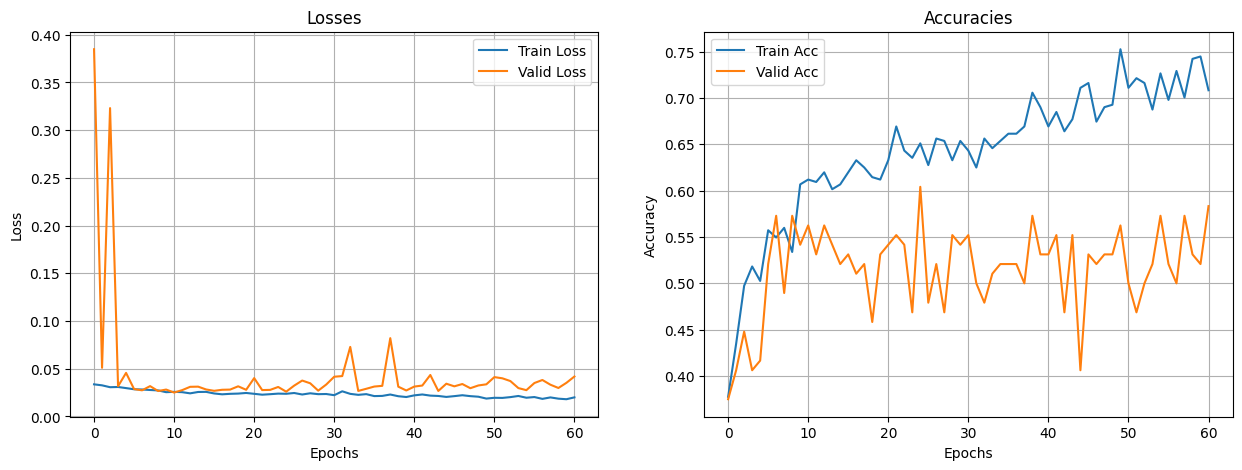

In [ ]:
# %%script false --no-raise-error

def plots_curves(train_loss, valid_loss, train_acc, valid_acc):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(train_loss, label="Train Loss")
    axes[0].plot(valid_loss, label="Valid Loss")
    axes[0].set_title("Losses")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid()
    axes[1].plot(train_acc, label="Train Acc")
    axes[1].plot(valid_acc, label="Valid Acc")
    axes[1].set_title("Accuracies")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid()

    plt.show()

plots_curves(train_losses, valid_losses, train_accs, valid_accs)

In [ ]:
#%%script false --no-raise-error

def testing(test_loader=None, model=None, device=None):
    if test_loader is None:
        raise ValueError("test_loader cannot be None.")
    if model is None:
        raise ValueError("model cannot be None.")
    if device is None:
        raise ValueError("device cannot be None.")

    model.eval()
    test_loss = .0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    return test_loss, all_preds, all_targets

Test Loss: 0.0305
Accuracy:  0.5917
Precision: 0.5898
Recall:    0.5917


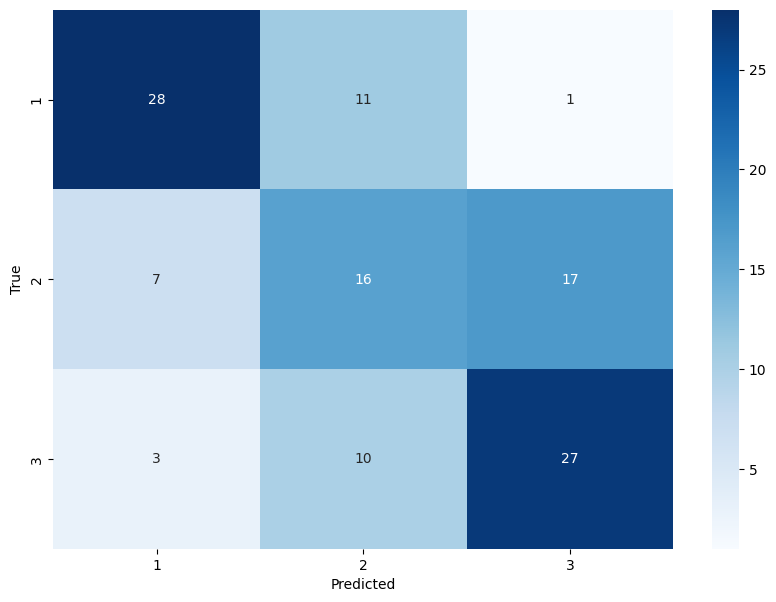

In [ ]:
#%%script false --no-raise-error

model = ResNet34Pretrained()
model.load_state_dict(torch.load("/Users/roberto/Desktop/FINALP/checkpoints/model_final.pth"))
model = model.to(device)

test_loss, all_preds, all_targets = testing(test_loader, model, device)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_targets, all_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

class_names = ["1", "2", "3"]
plot_confusion_matrix(all_targets, all_preds, class_names)

In [ ]:
#%%script false --no-raise-error

import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

class RemoveContoursTransform:
    def __init__(self, blur_value=5):
        self.blur_value = blur_value

    def __call__(self, img):
        # Converti l'immagine PIL in un array NumPy
        img_np = np.array(img)

        # Applica la sfocatura all'immagine
        blurred_img_np = cv2.GaussianBlur(img_np, (self.blur_value, self.blur_value), 0)

        # Converti l'immagine NumPy nuovamente in un oggetto PIL e restituiscila
        return Image.fromarray(blurred_img_np)


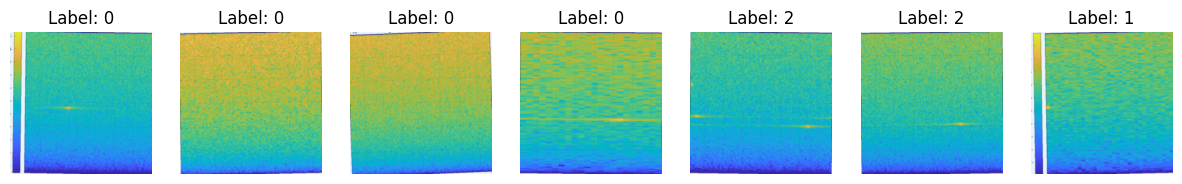

In [ ]:
#%%script false --no-raise-error
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
import numpy as np
from torchvision import datasets


# Funzione per ottenere i loader di addestramento e convalida
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.2,   ###percentuale del validation set , io ho train e test e non validation , dunque sto dicendo :
                           shuffle=True):    ###prendi il 20% del train e usalo per fare la validation !

    # Normalizzazione delle immagini
    normalize = transforms.Normalize(     ### valori medi per i coliri rgb sepmre
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    augument_transform = transforms.Compose([
        transforms.RandomRotation(2),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.001)
    ])

    crop = transforms.Lambda(lambda x: x[:,49:584, 102:708])

    # Trasformazioni per il set di convalida
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((224, 224)),
        normalize
    ])

    # Trasformazioni per il set di addestramento
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((224, 224)),
        normalize
    ])

    if augment:
        train_transform.transforms.insert(0, augument_transform)


    # Carica il dataset "TargetSpaziali" per addestramento e convalida
    train_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Cartella del set di addestramento
        transform=train_transform,
    )


    valid_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Utilizza la stessa cartella del set di addestramento per la convalida
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    # Se richiesto, mescola gli indici
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    # Suddivide gli indici per ottenere gli indici per addestramento e convalida
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Crea i DataLoader per addestramento e convalida
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)


    return (train_loader, valid_loader)


# Funzione per ottenere il DataLoader per il set di test
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
        #mean=[0.485, 0.456, 0.406],
        #std=[0.229, 0.224, 0.225],
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    #Uso una funzione lambda per tagliare l'immagine alle dimensioni specificate, mantenendo tutti i suou canali (RGB)

    crop = transforms.Lambda(lambda x: x[:,49:584, 102:708])


    # Trasformazioni per il set di test
    transform = transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((224, 224)),
        normalize,
    ])

    # Carica il dataset "TargetSpaziali" per il test
    test_dataset = datasets.ImageFolder(
        root=data_dir + '/test',  # Cartella del set di test
        transform=transform,
    )

    # Crea il DataLoader per il set di test
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle)

    return test_loader


# Esempio di utilizzo delle funzioni per ottenere i DataLoader
# targetspaziali dataset
train_loader, valid_loader = get_train_valid_loader(
    data_dir='/Users/roberto/Desktop/FINALP/TargetSpaziali', batch_size=32,
    augment=True, random_seed=1
)

test_loader = get_test_loader(
    data_dir='/Users/roberto/Desktop/FINALP/TargetSpaziali', batch_size=32
)

# Funzione per visualizzare alcune immagini dal DataLoader
def show_images(loader, num_images=7):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    # Ottieni un iteratore dal DataLoader
    data_iter = iter(loader)

    # Estrai il prossimo batch dal DataLoader
    images, labels = next(data_iter)

    # Visualizza le immagini e le relative etichette
    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min())
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

# Visualizza alcune immagini dal DataLoader di addestramento
show_images(train_loader)


ResNet18

In [ ]:
# save the model
torch.save(model.state_dict(), 'model.pth')

ora provo una rete piu semplice con meno strati :


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool2d(2)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # Assuming the input dimensions are (3, 32, 32), the output dimensions after convolutions are (128, 32, 32)
        # This assumes no pooling layers are used. If pooling is used, dimensions will change accordingly.
        self.fc1 = nn.Linear(64 * 25 * 25, 128)  # First linear layer
        self.fc2 = nn.Linear(128, num_classes)    # Second linear layer

    def forward(self, x):
        # Apply first convolution with relu
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolution with relu
        x = self.pool(F.relu(self.conv2(x)))

        # Apply third convolution with relu
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the linear layer
        x = x.view(x.size(0), -1)

        x = F.dropout(x, 0.25)   ####0.3 e via abbasando

        # Apply the first linear layer with relu
        x = F.relu(self.fc1(x))

        # Apply the second linear layer
        x = self.fc2(x)

        return x

In [ ]:
# Numero di classi nel problema di classificazione
num_classes = 3

# Numero di epoche per l'addestramento
num_epochs = 47

# Dimensione del batch durante l'addestramento
batch_size = 64

# Tasso di apprendimento per l'ottimizzatore
learning_rate = 0.001   #0.1-0.001

# Creazione di un'istanza del modello e spostamento del modello sulla GPU (se disponibile)
model = CustomCNN(num_classes).to(device)

# Definizione della funzione di perdita (cross-entropy) e dell'ottimizzatore (ADAM)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)     #### 0.005 a diminuire , aggiungi zeri....

# Numero totale di passaggi (batches) nell'addestramento, determinato dalla lunghezza del DataLoader di addestramento
total_step = len(train_loader)


In [ ]:
# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
    total = 0
    correct = 0
    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Stampa l'informazione sull'andamento dell'addestramento (epoca corrente, passaggio corrente, perdita corrente)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Acc: {}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), round(100*correct/total,2)))

    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs

        # Stampa l'accuratezza del modello sulla convalida
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader.dataset), round(100 * correct / total,2)))


Epoch [1/47], Step [12/12], Loss: 1.0603, Train Acc: 35.16%
Accuracy of the network on the 480 validation images: 44.79 %
Epoch [2/47], Step [12/12], Loss: 1.0332, Train Acc: 41.67%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [3/47], Step [12/12], Loss: 1.0178, Train Acc: 38.28%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [4/47], Step [12/12], Loss: 0.9887, Train Acc: 41.67%
Accuracy of the network on the 480 validation images: 47.92 %
Epoch [5/47], Step [12/12], Loss: 1.2338, Train Acc: 40.62%
Accuracy of the network on the 480 validation images: 52.08 %
Epoch [6/47], Step [12/12], Loss: 1.0406, Train Acc: 41.93%
Accuracy of the network on the 480 validation images: 52.08 %
Epoch [7/47], Step [12/12], Loss: 1.0259, Train Acc: 40.62%
Accuracy of the network on the 480 validation images: 52.08 %
Epoch [8/47], Step [12/12], Loss: 1.1797, Train Acc: 43.49%
Accuracy of the network on the 480 validation images: 46.88 %
Epoch [9/47], Step [12/1

Precision on the 120 test images: 0.43
Recall on the 120 test images: 0.42
Accuracy on the 120 test images: 0.42


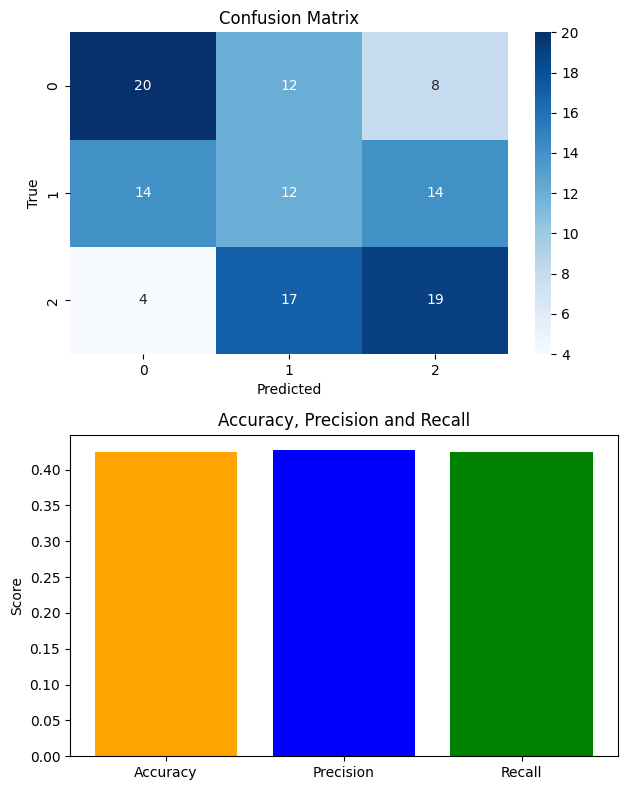

In [ ]:


# Test del modello su dati di test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    # Ciclo su ogni batch nel DataLoader di test
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Ottieni le predizioni e calcola le metriche di valutazione
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Libera memoria rimuovendo i tensori temporanei
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)

    # Stampa le metriche di valutazione
    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)

    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(3)), yticklabels=list(range(3)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall'], [test_accuracy, test_precision, test_recall], color=['orange', 'blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy, Precision and Recall')

    # Aggiusta la disposizione dei subplot
    plt.tight_layout()

    # Mostra i grafici
    plt.show()
